In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

In [2]:
# Determine the number of opa sequences in each genome that were excluded because of frameshift mutation downstream of the N-terminus

# Import list of excluded opa genes
excluded = pd.read_csv('../../results/opa_sequences_aa/opa_sequences_excluded_in_alignment.csv')

# Add strain info
for i, row in excluded.iterrows():
    strain = row['opa_gene'].split("_opa_")[0]
    excluded.loc[i,'strain'] = strain

# Get summary of number excluded per strain
strains = []
num_excluded = []
for strain, df in excluded.groupby('strain'):
    strains.append(strain)
    num_excluded.append(len(df))
num_excluded_df = pd.DataFrame({'strain':strains, 'num_excluded':num_excluded})

# Get total number of excluded opa genes
print('total_excluded: ', len(excluded))

total_excluded:  156


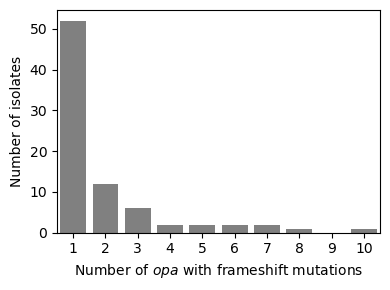

In [3]:
# Plot the distribution of excluded opa genes by strain
plt.figure(figsize = (4,3))
sns.countplot(num_excluded_df, x = 'num_excluded', order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], color = 'gray')
plt.xlabel('Number of $opa$ with frameshift mutations')
plt.ylabel('Number of isolates')
plt.tight_layout()
plt.savefig('../../figures/frame/post_Nterm_dist_frameshift.png', dpi = 300)
plt.show()

In [4]:
# Note that none of the opas from the WHO sequences are excluded

In [5]:
# Determine how many of the isolates were sequenced by our lab

strains = []
source = []
for filenames in glob.glob('../../input_data/complete_genome_assemblies/grad_lab/*.fa'):
    strains.append(filenames.split('/')[-1].split('.fa')[0])
    source.append('grad_lab')

for filenames in glob.glob('../../input_data/complete_genome_assemblies/public*/*.fa'):
    strains.append(filenames.split('/')[-1].split('.fa')[0])
    source.append('public')

metadata = pd.DataFrame({'strain':strains, 'source':source})
merged = num_excluded_df.merge(metadata, on = 'strain', how = 'left')

total_public = len(metadata[metadata['source']=='public'])
total_grad_lab = len(metadata[metadata['source']=='grad_lab'])
print('Publicly available:', len(merged[merged['source']=='public']), 'out of', total_public, '(', round(len(merged[merged['source']=='public'])/total_public,2), ')' )
print('Grad lab sequenced:', len(merged[merged['source']=='grad_lab']), 'out of', total_grad_lab, '(', round(len(merged[merged['source']=='grad_lab'])/total_grad_lab,2), ')')

Publicly available: 51 out of 132 ( 0.39 )
Grad lab sequenced: 29 out of 87 ( 0.33 )


In [8]:
# Get the metrics for sequencing depth
grad_lab_metrics = pd.read_csv('../../input_data/complete_genome_assemblies/grad_lab/metrics.tsv', sep = '\t')
grad_lab_metrics['strain'] = grad_lab_metrics['name'].str.split('/', expand = True)[1]
grad_lab_metrics['approx_coverage'] = grad_lab_metrics['input_read_bases']/grad_lab_metrics['consensus_assembly_bases']

metrics_merged = merged.merge(grad_lab_metrics, on = 'strain', how = 'right')

# If no opas were excluded, indicate that
metrics_merged['num_excluded'].fillna(0, inplace = True)

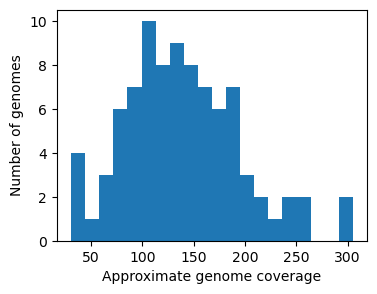

In [9]:
# Plot overall genome coverage
plt.figure(figsize = (4,3))
plt.hist(metrics_merged['approx_coverage'], bins = 20)
plt.xlabel('Approximate genome coverage')
plt.ylabel('Number of genomes')
plt.show()

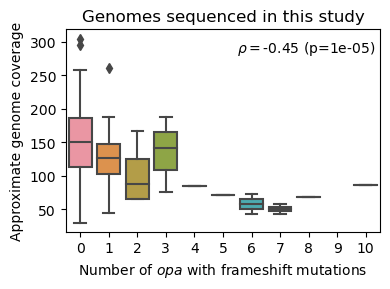

In [27]:
# Calculate spearman correlation coefficient
res = stats.spearmanr(metrics_merged['num_excluded'], metrics_merged['approx_coverage'])
rho = res.statistic
p = res.pvalue

# Plot number of excluded opas vs genome coverage
plt.figure(figsize = (4,3))
sns.boxplot(data = metrics_merged, x = 'num_excluded', y = 'approx_coverage', order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.text(5.5, 285, '$\\rho=$' + str(round(rho,2)) + ' (p=' + str(round(p,5)) + ')')
plt.xlabel('Number of $opa$ with frameshift mutations')
plt.ylabel('Approximate genome coverage')
plt.title('Genomes sequenced in this study')
plt.tight_layout()
plt.savefig('../../figures/frame/post_Nterm_num_opa_frameshift_vs_coverage.png', dpi = 300)
plt.savefig('../../figures/frame/post_Nterm_num_opa_frameshift_vs_coverage.pdf')
plt.show()

In [28]:
# Get the location of the stop codons
filename = "../../results/opa_sequences_aa/opa_sequences_aa.fa.all"
opa_genes = SeqIO.to_dict(SeqIO.parse(filename, "fasta"))
opa_genes_to_exclude = []
stop_loc = []
total_len = []
strains = []
# records = []
for opa_gene in opa_genes:
    strain = opa_gene.split('_opa_')[0]
    # Exclude if the final 21 codons (including stop codon) have more than 4 errors OR there is a premature stop codon.
    # Checked that all of the opa genes where this sequence was found had fewer than 4 errors.
    seq = opa_genes[opa_gene].seq
    if str(seq).find('*')<(len(seq)-1):
        opa_genes_to_exclude.append(opa_gene)
        stop_loc.append(str(seq).find('*'))
        total_len.append(len(seq)-1)
        strains.append(strain)
    # else:
        # records.append(opa_genes[opa_gene])

excluded_summary = pd.DataFrame({'opa_gene':opa_genes_to_exclude, 'strain':strains, 'stop_loc':stop_loc, 'total_len':total_len})

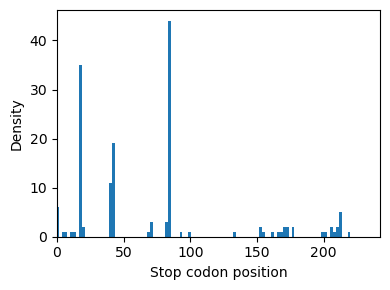

In [29]:
# Plot the location of the stop codons

avg_opa_len = np.mean(excluded_summary['total_len'])

plt.figure(figsize = (4,3))
plt.hist(excluded_summary['stop_loc'], 100)
plt.xlabel('Stop codon position')
plt.ylabel('Density')
plt.xlim([0, avg_opa_len])
plt.tight_layout()
plt.savefig('../../figures/frame/post_Nterm_frameshift_stop_codon_location.png', dpi = 300)
plt.savefig('../../figures/frame/post_Nterm_frameshift_stop_codon_location.pdf')
plt.show()

In [ ]:
# Import reference sequence FA1090_opa_1
reference_opa = list(SeqIO.parse("../../resources/FA1090_opa_1_reference.fa", "fasta"))[0]

reference_opa_aa = list(SeqIO.parse("../../results/opa_sequences_aa/FA1090.fa", "fasta"))[0]

In [ ]:
# Split into 4 main types and save the nucleotide sequences for further inspection

excluded_ranges = {1:[-2,0], 2:[15,20], 3:[35,45], 4:[80, 88]}
for excluded_range in excluded_ranges:
    excluded_summary_subset = excluded_summary[(excluded_summary['stop_loc']<excluded_ranges[excluded_range][1])&(excluded_summary['stop_loc']>excluded_ranges[excluded_range][0])]
    excluded_seqs = []
    # Add the reference opa
    excluded_seqs.append(reference_opa)
    for strain, df in excluded_summary_subset.groupby('strain'):
        for record in SeqIO.parse("../../results/opa_sequences_no_repeats/" + strain + ".fa", "fasta"):
            if record.id in df['opa_gene'].values:
                excluded_seqs.append(SeqRecord(
                    Seq(record.seq),
                    id=record.id,
                    name=record.name,
                    description=record.description))

    SeqIO.write(excluded_seqs, "../../results/frameshift/excluded_opa_genes_nt_type" + str(excluded_range) + ".fa", "fasta")

In [ ]:
# Save the nucleotide and amino acid sequences of all excluded opa for further inspection

# Nucleotide
excluded_seqs = []
# Add the reference opa
excluded_seqs.append(reference_opa)
for strain, df in excluded_summary.groupby('strain'):
    for record in SeqIO.parse("../../results/opa_sequences_no_repeats/" + strain + ".fa", "fasta"):
        if record.id in df['opa_gene'].values:
            excluded_seqs.append(SeqRecord(
                Seq(record.seq),
                id=record.id,
                name=record.name,
                description=record.description))

SeqIO.write(excluded_seqs, "../../results/frameshift/excluded_opa_genes_nt.fa", "fasta")

# Amino acid
excluded_seqs = []
# Add the reference opa
excluded_seqs.append(reference_opa_aa)
for strain, df in excluded_summary.groupby('strain'):
    for record in SeqIO.parse("../../results/opa_sequences_aa/" + strain + ".fa", "fasta"):
        if record.id in df['opa_gene'].values:
            excluded_seqs.append(SeqRecord(
                Seq(record.seq),
                id=record.id,
                name=record.name,
                description=record.description))

SeqIO.write(excluded_seqs, "../../results/frameshift/excluded_opa_genes_aa.fa", "fasta")

157